In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyelsa as elsa
from reconstruction import XrayOperator, feldkamp

pyelsa not build with CUDA projector support


### 3D cone-beam reconstruction (Equidistant case/ flat detector)

First, we perform the forward projection to obtain the sinogram

\begin{equation}
   p(s,t;\beta) = \int_{L(s,t;\beta)} f(x,y,z) \,dl
\end{equation}

In [16]:
size = np.array([64, 64, 64])
phantom = np.rot90(elsa.phantoms.modifiedSheppLogan(size), -1)

num_angles = 180
arc = 360

s2c = size[0] * 100
c2d = size[0] 
sd = s2c + c2d

projector = feldkamp.Feldkamp(size, [120,120], np.linspace(0, arc, num_angles), s2c, c2d, cor_offset=[0,0,0],pp_offset=[0,0])
sino = projector.apply(phantom)


[2024-01-06 18:35:31.533] [phantom::modifiedSheppLogan] [info] creating modified Shepp Logan phantom of size 64^3
[2024-01-06 18:35:31.535] [phantom::modifiedSheppLogan] [info] rasterize Ellipsoid with amplitude 1, center (32,32,32) , half axis (22,29,26) euler angels (0,0,0)
[2024-01-06 18:35:31.536] [phantom::modifiedSheppLogan] [info] rasterize Ellipsoid with amplitude -0.8, center (32,31,32) , half axis (21,28,25) euler angels (0,0,0)
[2024-01-06 18:35:31.538] [phantom::modifiedSheppLogan] [info] rasterize Ellipsoid with amplitude -0.2, center (39,32,32) , half axis (3,10,7) euler angels (-18,0,10)
[2024-01-06 18:35:31.538] [phantom::modifiedSheppLogan] [info] rasterize Ellipsoid with amplitude -0.2, center (25,32,32) , half axis (5,13,9) euler angels (18,0,10)
[2024-01-06 18:35:31.538] [phantom::modifiedSheppLogan] [info] rasterize Ellipsoid with amplitude 0.1, center (32,43,27) , half axis (7,8,13) euler angels (0,0,0)
[2024-01-06 18:35:31.538] [phantom::modifiedSheppLogan] [info

Visualize the phantom and the sinogram at different slice

Text(0.5, 1.0, 'Sinogram - slice 60 (dim 2)')

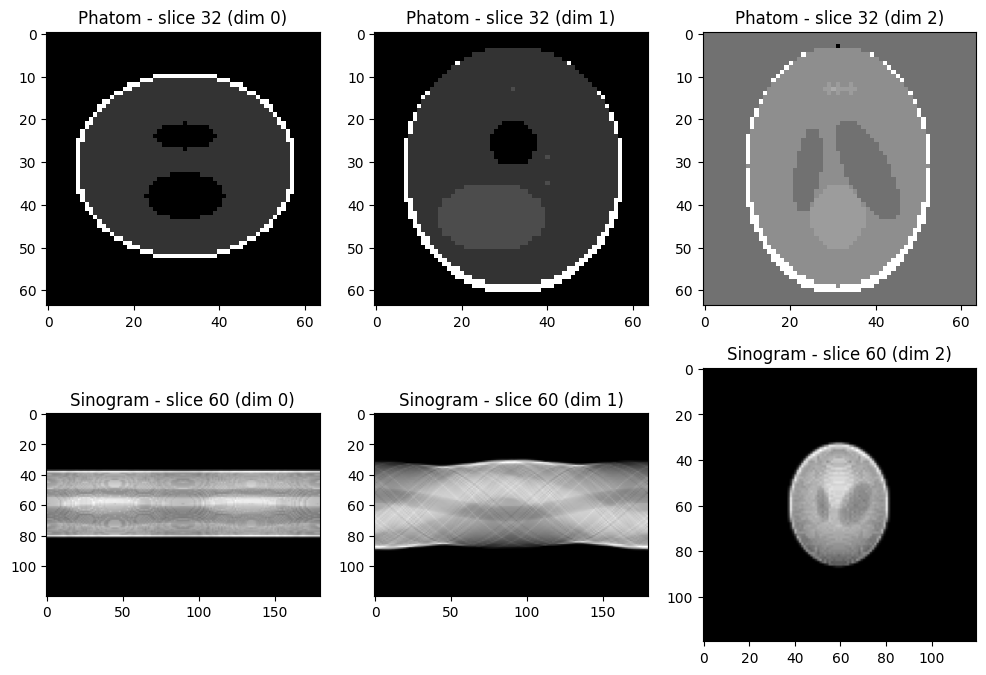

In [17]:
# Visualize slices at the middle
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3 , figsize=(12, 8))

ax1.imshow(phantom[32,:,:], cmap="gray")
ax1.set_title("Phatom - slice 32 (dim 0)")
ax2.imshow(phantom[:,32,:], cmap="gray")
ax2.set_title("Phatom - slice 32 (dim 1)")
ax3.imshow(phantom[:,:,32], cmap="gray")
ax3.set_title("Phatom - slice 32 (dim 2)")
ax4.imshow(sino[60,:,:], cmap="gray")
ax4.set_title("Sinogram - slice 60 (dim 0)")
ax5.imshow(sino[:,60,:], cmap="gray")
ax5.set_title("Sinogram - slice 60 (dim 1)")
ax6.imshow(sino[:,:,60], cmap="gray")
ax6.set_title("Sinogram - slice 60 (dim 2)")


Apply the Feldkamp conebeam algorithm or FDK approach (Reminder!!)


Step 1. Compute weighted projections using the  projection weighting $w_{1}(s,t)p(s,t;\beta)$

\begin{equation}
   \overline{p}(s,t;\beta) = w_{1}(s,t)p(s,t;\beta), \,\,\,\,\,\,\,\,\,\, w_{1}(s,t) = \frac{D_{so}}{\sqrt{D_{sd}^2+s^2+t^2}}
\end{equation}

Step 2. Filter those weighted projections (along s) for each ${\beta}$ using the ordinary ramp filter $h_{*}(s)$ from equation (20)

\begin{equation}
    \overline{p}(s,t;\beta) = \overline{p}(s,t;\beta) * h_{*}(s)
\end{equation}

\begin{equation}
h[n] =
\left\{
	\begin{array}{ll}
		1,  & n=0 \\
		0 ,  & \text{n even } \\
            \frac{-1}{(\pi n/2)^2 } ,  & \text{n odd } 
	\end{array}
\right.
\end{equation}

Step 3. Perform weighted cone-beam backprojection of those filtered projections

\begin{equation}
    \hat{f}(x,y,z) = \frac{1}{2} \int_{0}^{2\pi} w_{2}(x,y,\beta) \overline{p}(s_{\beta}(x,y),t_{\beta}(x,y,z);\beta) ,d\beta 
\end{equation}

\begin{equation}
    w_{2}(x,y,\beta)  = \frac{D_{sd}^2}{(D_{so}-y_{\beta})^2}  \,\,\,\,\,\,\,\,\,\,
    s_{\beta}(x,y) = \frac{D_{sd}}{D_{so}-y_{\beta}} x_{\beta}  \,\,\,\,\,\,\,\,\,\,
    t_{\beta}(x,y,z) = \frac{D_{sd}}{D_{so}-y_{\beta}} z
\end{equation}

In [4]:
recon = projector.applyAdjoint(sino)

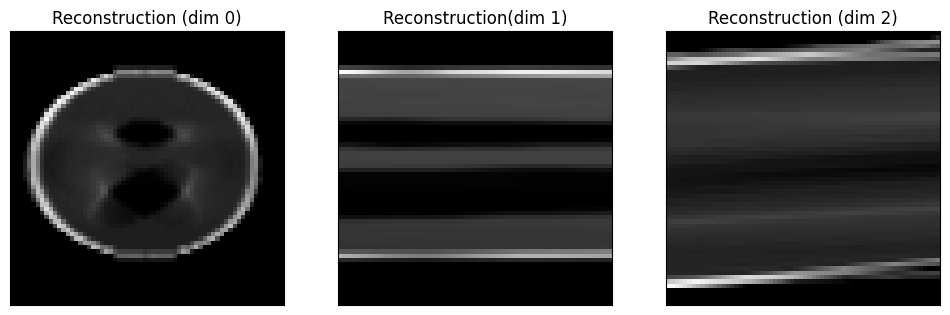

In [9]:
fig, (ax1, ax2, ax3) =  plt.subplots(1,3 , figsize=(12, 6))
ax1.imshow(recon[32,:,:].T, cmap="gray")
ax1.set_title("Reconstruction (dim 0)")
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)

ax2.imshow(recon[:,32,:].T, cmap="gray")
ax2.set_title("Reconstruction(dim 1)")
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)

ax3.imshow(recon[:,:,32].T, cmap="gray")
ax3.set_title("Reconstruction (dim 2)")
ax3.get_xaxis().set_visible(False)
ax3.get_yaxis().set_visible(False)

Reconstruction from library

In [6]:
projector2 = XrayOperator.XrayOperator(size, [120,120], np.linspace(0, arc, num_angles), s2c, c2d, cor_offset=[0,0,0],pp_offset=[0,0])
sino2 = projector2.apply(phantom)


recon2 = projector2.applyAdjoint(sino2)

[2024-01-06 16:34:48.920] [CircleTrajectoryGenerator] [info] creating 3D trajectory with 180 poses in an 360 degree arc


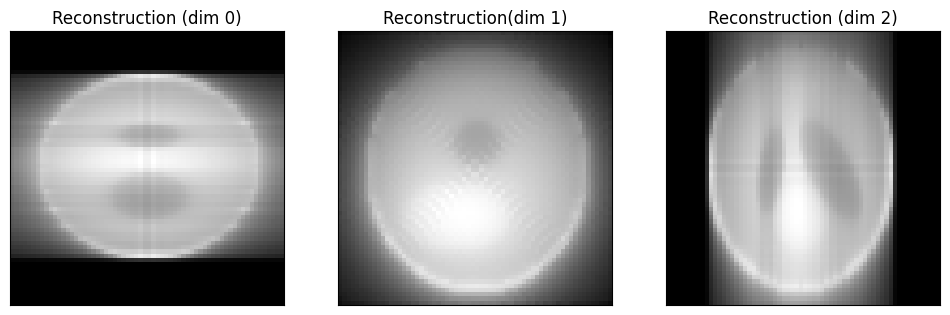

In [7]:
fig, (ax1, ax2, ax3) =  plt.subplots(1,3 , figsize=(12, 6))
ax1.imshow(recon2[32,:,:], cmap="gray")
ax1.set_title("Reconstruction (dim 0)")
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)

ax2.imshow(recon2[:,32,:], cmap="gray")
ax2.set_title("Reconstruction(dim 1)")
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)

ax3.imshow(recon2[:,:,32], cmap="gray")
ax3.set_title("Reconstruction (dim 2)")
ax3.get_xaxis().set_visible(False)
ax3.get_yaxis().set_visible(False)